# Semi-supervised surgery pipeline with SCANVI

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown

Global seed set to 0


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Set relevant anndata.obs labels and training length

Here we use the CelSeq2 and SS2 studies as query data and the other 3 studies as reference atlas.

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']

### Download Dataset and split into reference dataset and query dataset

In [5]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
To: C:\Users\sergei.rybakov\Projects\scarches\pancreas.h5ad
100%|██████████████████████████████████████████████████████████████████████████████████████████| 126M/126M [00:06<00:00, 20.8MB/s]


'pancreas.h5ad'

In [6]:
adata_all = sc.read('pancreas.h5ad')

This line makes sure that count data is in the adata.X. Remember that count data in adata.X is necessary when using "nb" or "zinb" loss.

In [7]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata[adata.obs[condition_key].isin(target_conditions)].copy()

In [8]:
source_adata

AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [9]:
target_adata

AnnData object with n_obs × n_vars = 5387 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

### Create SCANVI model and train it on fully labelled reference dataset

Preprocess reference dataset. Remember that the adata file has to have count data in adata.X for SCVI/SCANVI if not further specified

In [10]:
sca.models.SCANVI.setup_anndata(source_adata, batch_key=condition_key, labels_key=cell_type_key, unlabeled_category="Unknown")

INFO     Using batches from adata.obs["study"]                                               
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 10294 cells, 1000 vars, 3 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [11]:
vae = sca.models.SCVI(
    source_adata,
    n_layers=2,
    encode_covariates=True,
    deeply_inject_covariates=False,
    use_layer_norm="both",
    use_batch_norm="none",
)

In [12]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|███████| 400/400 [03:28<00:00,  1.92it/s, loss=502, v_num=1]


Create the SCANVI model instance with ZINB loss as default. Insert "gene_likelihood='nb'," to change the reconstruction loss to NB loss.

In [13]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, "Unknown")

In [14]:
print("Labelled Indices: ", len(scanvae._labeled_indices))
print("Unlabelled Indices: ", len(scanvae._unlabeled_indices))

Labelled Indices:  10294
Unlabelled Indices:  0


In [15]:
scanvae.train(max_epochs=20)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20/20: 100%|███████████| 20/20 [00:21<00:00,  1.09s/it, loss=533, v_num=1]


### Create anndata file of latent representation and compute UMAP

In [16]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


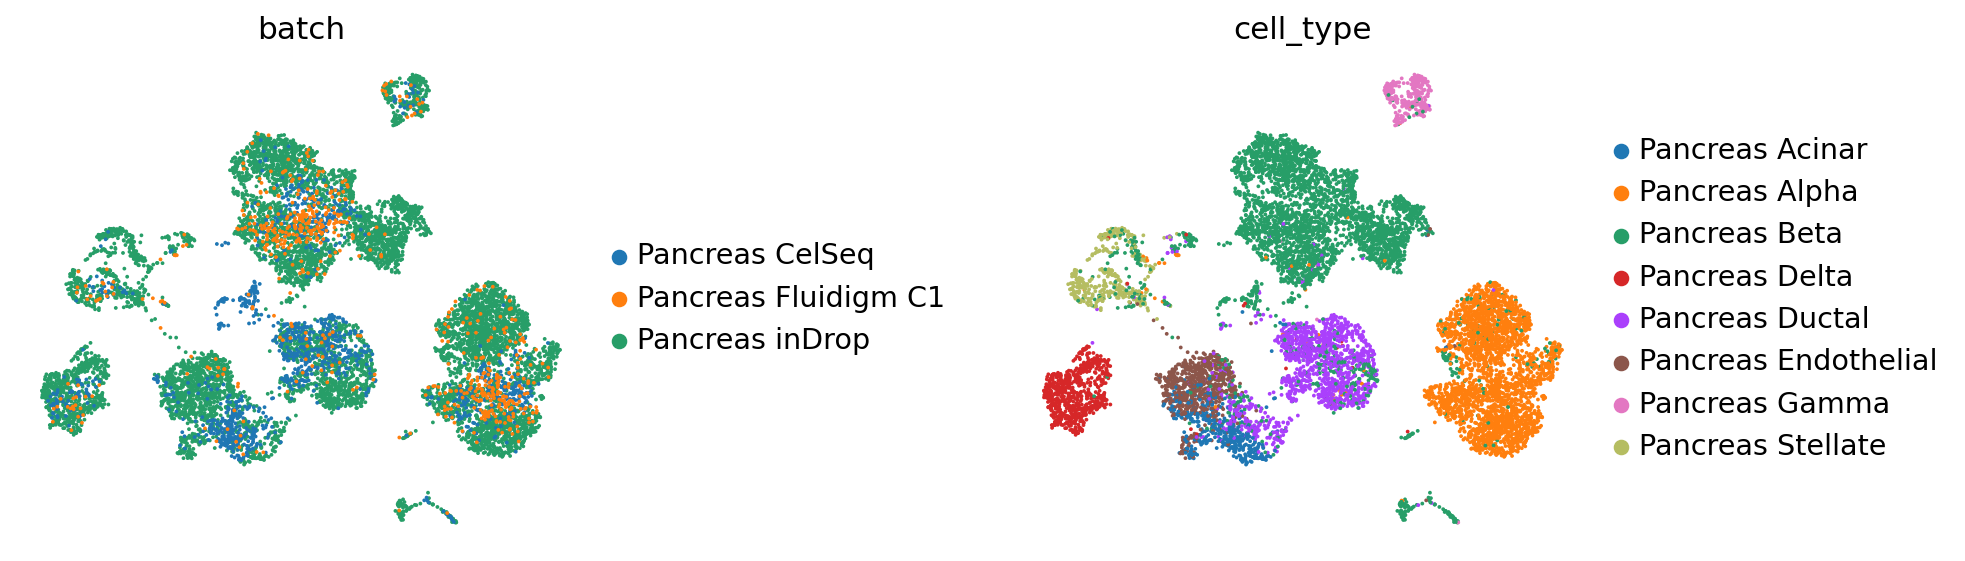

In [17]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

One can also compute the accuracy of the learned classifier

In [18]:
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.944530794637653


After pretraining the model can be saved for later use

In [19]:
ref_path = 'ref_model/'
scanvae.save(ref_path, overwrite=True)

### Perform surgery on reference model and train on query dataset without cell type labels

If the cell types in 'target_adata' are equal to or a subset of the reference data cell types, one can just pass the adata without further preprocessing. It is also possible then to do semi-supervised training with scArches.

However if there are new cell types in 'target_adata' or if there is no '.obs' in the anndata for cell type labels (e.g. the data is unlabeled), one can only use scANVI in an unsupervised manner during surgery due to the nature of the classifier. 

In addition one has to preprocess 'target_adata' in the following way:

If there are new celltypes in there, save the original labels in other column and replace all labels with unlabeled category:

If there is no '.obs' column for cell types:

If 'target_adata' is in the right format, one can proceed with the surgery pipeline. Here we do the surgery unsupervised, but due to the overlapping cell types in query and reference data, one could also do supervised or semi-supervised surgery by setting the indices accordingly.

In [20]:
model = sca.models.SCANVI.load_query_data(
    target_adata,
    ref_path,
    freeze_dropout = True,
)
model._unlabeled_indices = np.arange(target_adata.n_obs)
model._labeled_indices = []
print("Labelled Indices: ", len(model._labeled_indices))
print("Unlabelled Indices: ", len(model._unlabeled_indices))

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 5387 cells, 1000 vars, 5 batches, 
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
Labelled Indices:  0
Unlabelled Indices:  5387


In [21]:
model.train(
    max_epochs=100,
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██| 100/100 [00:46<00:00,  2.15it/s, loss=1.23e+03, v_num=1]


In [22]:
query_latent = sc.AnnData(model.get_latent_representation())
query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

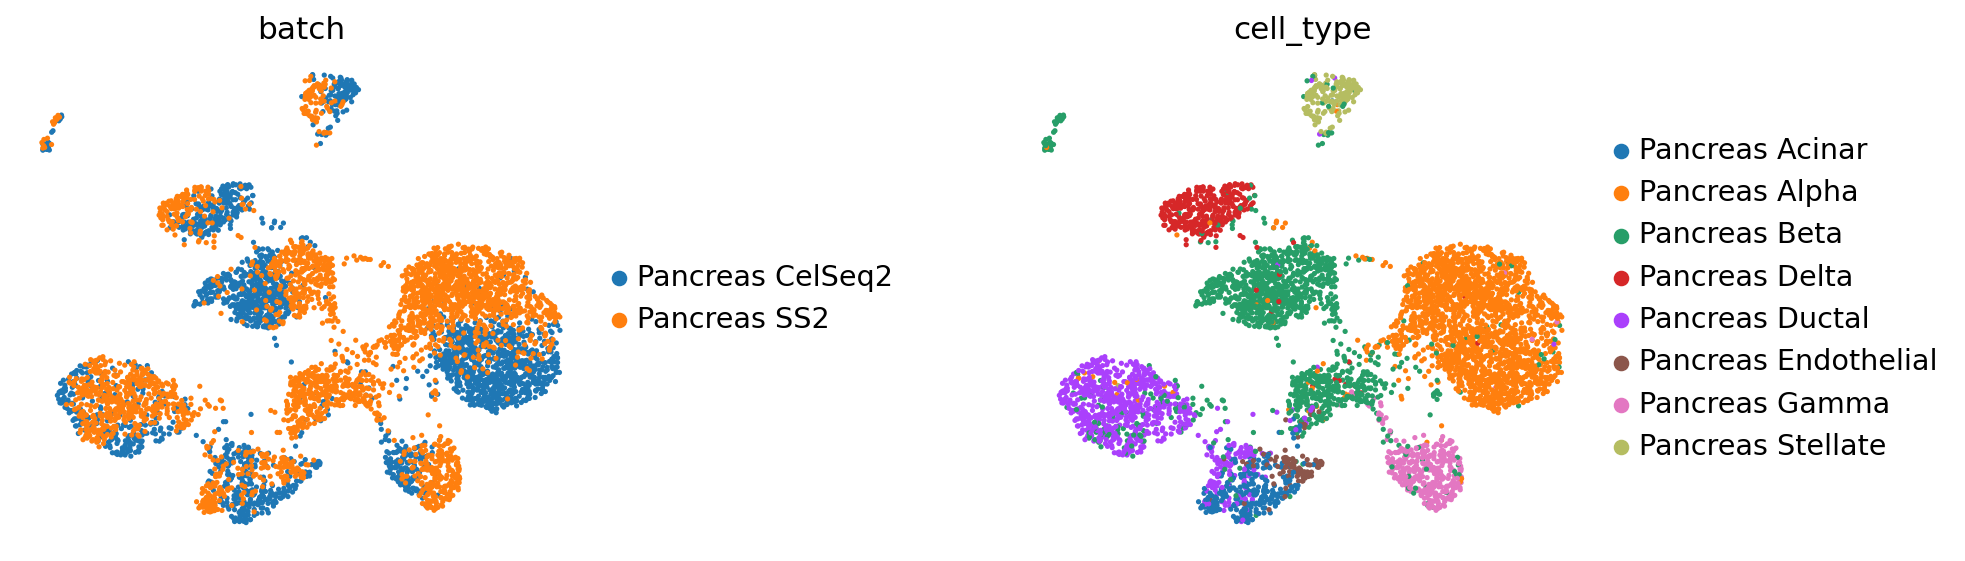

In [23]:
sc.pp.neighbors(query_latent)
sc.tl.leiden(query_latent)
sc.tl.umap(query_latent)
plt.figure()
sc.pl.umap(
    query_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

In [24]:
surgery_path = 'surgery_model'
model.save(surgery_path, overwrite=True)

### Compute Accuracy of model classifier for query dataset and compare predicted and observed cell types

In [25]:
query_latent.obs['predictions'] = model.predict()
print("Acc: {}".format(np.mean(query_latent.obs.predictions == query_latent.obs.cell_type)))

Acc: 0.8977167254501578


Text(0, 0.5, 'Observed')

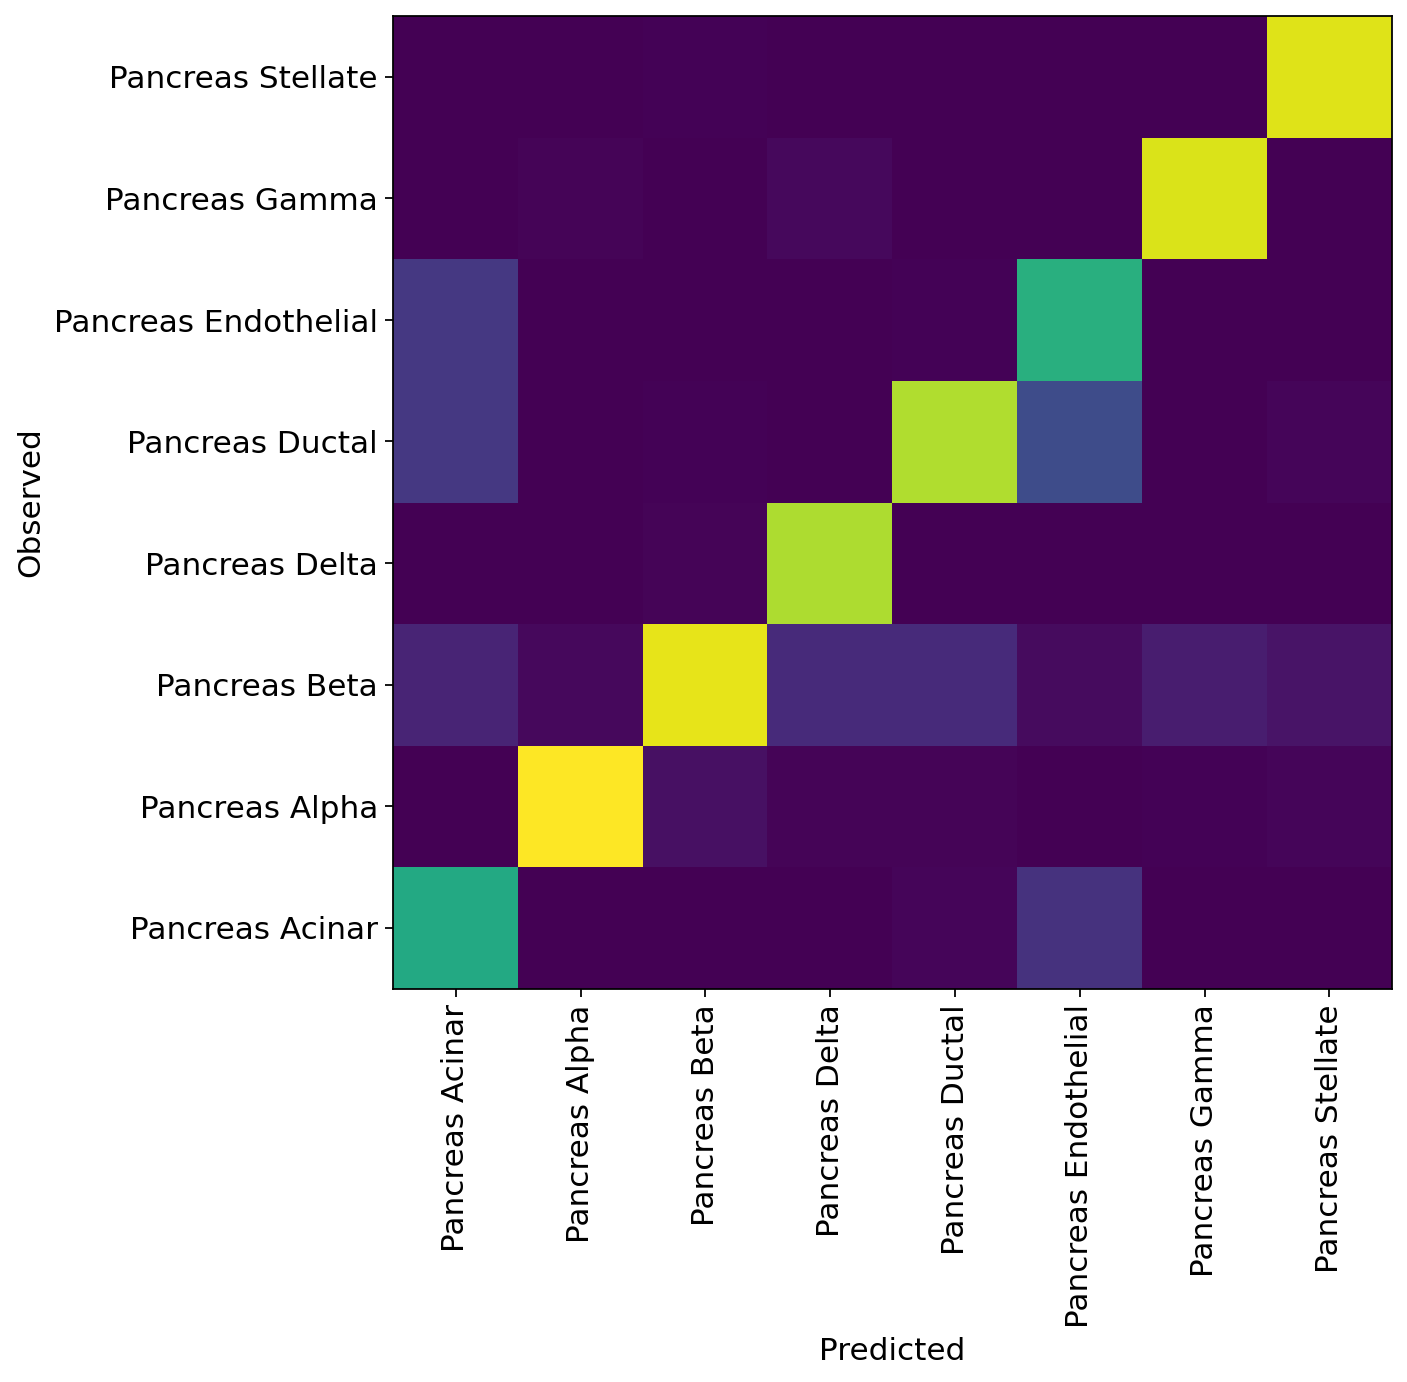

In [26]:
df = query_latent.obs.groupby(["cell_type", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")

### Get latent representation of reference + query dataset and compute UMAP

In [27]:
adata_full = source_adata.concatenate(target_adata)
full_latent = sc.AnnData(model.get_latent_representation(adata=adata_full))
full_latent.obs['cell_type'] = adata_full.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata_full.obs[condition_key].tolist()

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 15681 cells, 1000 vars, 5 batches,
         8 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


... storing 'cell_type' as categorical
... storing 'batch' as categorical


<Figure size 320x320 with 0 Axes>

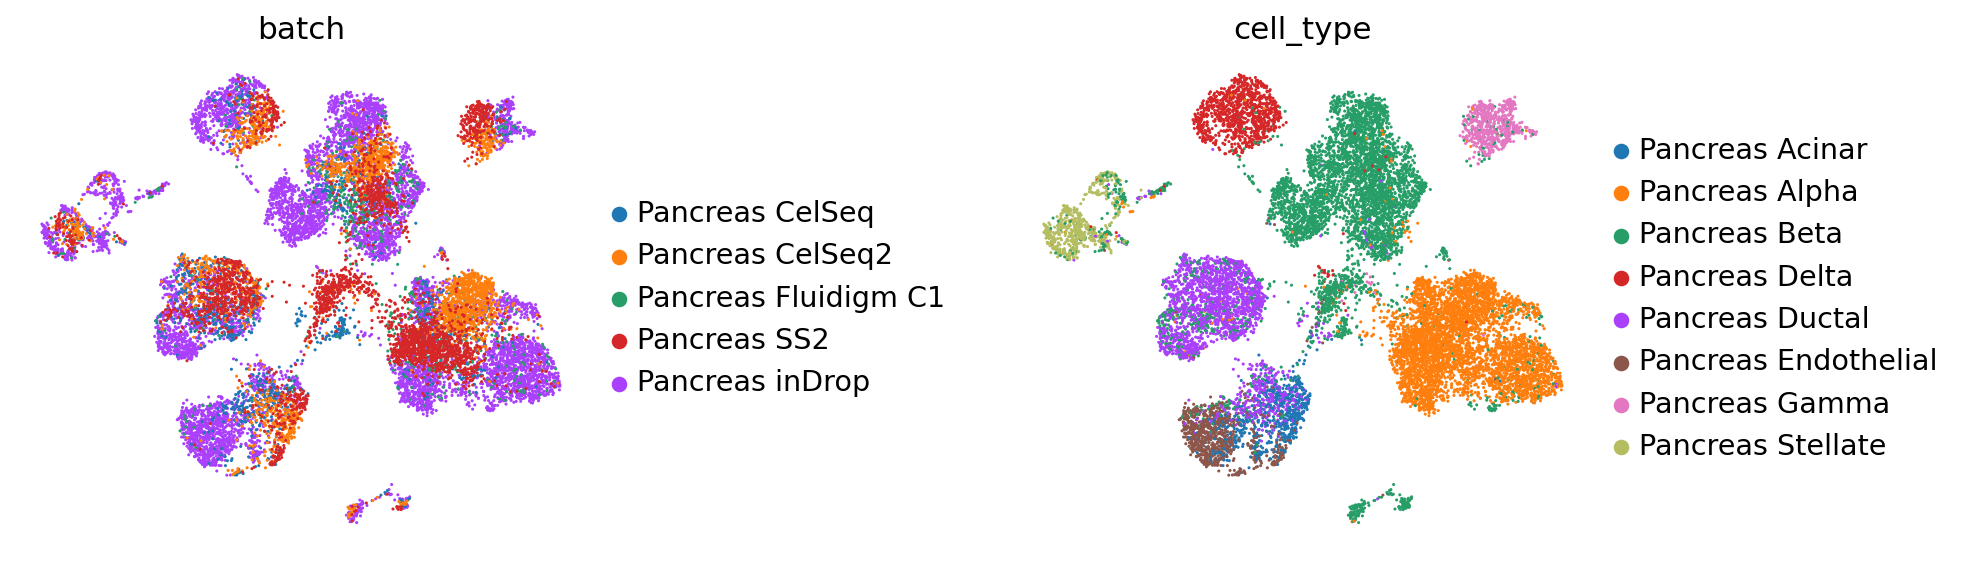

In [28]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["batch", "cell_type"],
    frameon=False,
    wspace=0.6,
)

### Comparison of observed and predicted celltypes for reference + query dataset

In [29]:
full_latent.obs['predictions'] = model.predict(adata=adata_full)
print("Acc: {}".format(np.mean(full_latent.obs.predictions == full_latent.obs.cell_type)))

Acc: 0.9284484407882151


... storing 'predictions' as categorical


<Figure size 320x320 with 0 Axes>

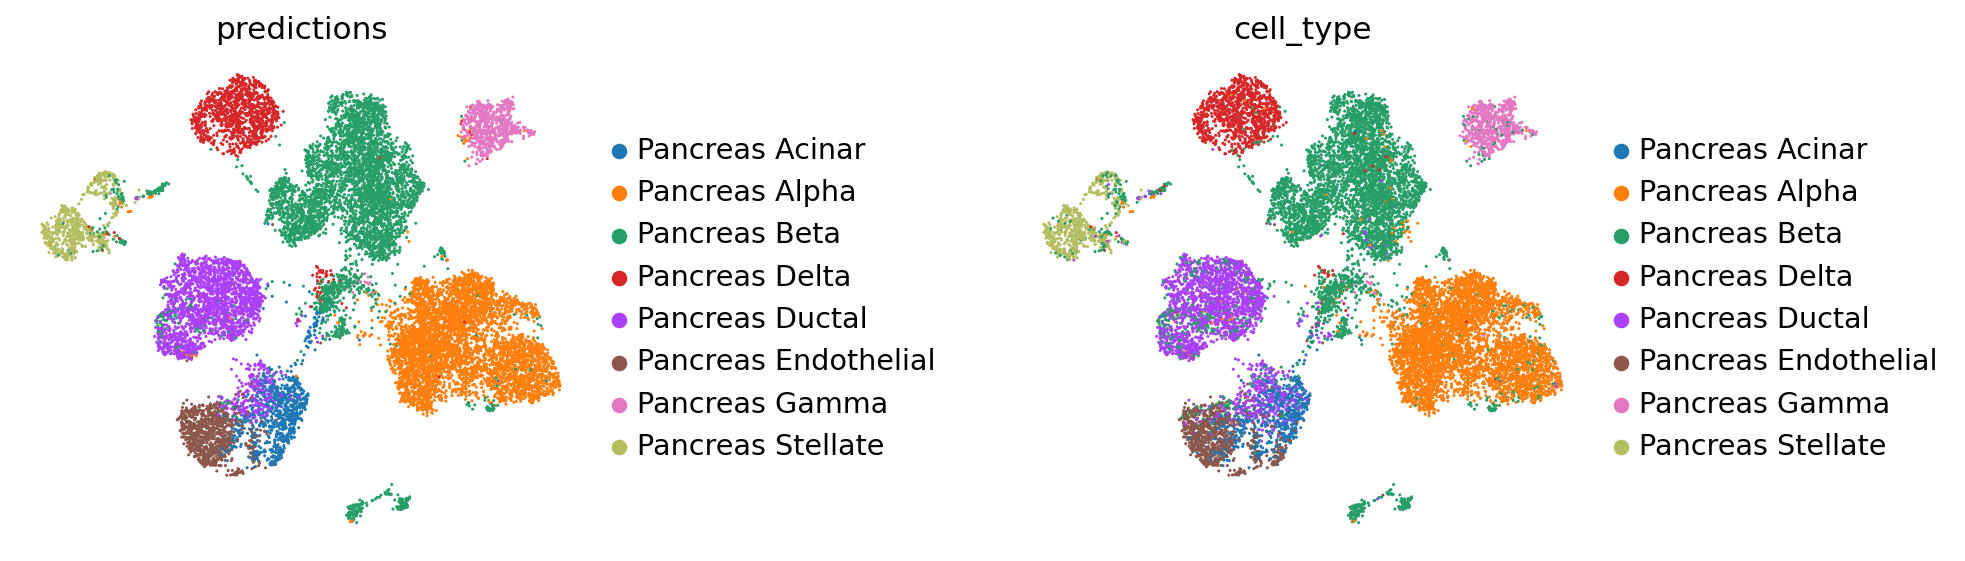

In [30]:
sc.pp.neighbors(full_latent)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
plt.figure()
sc.pl.umap(
    full_latent,
    color=["predictions", "cell_type"],
    frameon=False,
    wspace=0.6,
)